<a id="top"></a>
# Surveying dust structure via GALEX MIS
***

## Learning goals

By the end of this tutorial you will be able to:

- Understand NUV and FUV images and how they are useful to study dust
- Navigate the GALEX MIS catalog
- Learn how to adjust the constrast of an image using `ZScaleInterval`
- Create a mosaic from several images

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS) spectroscopic footprint. The MIS has been extended to cover the Two Degree Field Galaxy Redshift Survey (2dFGRS) and the AA-Omega (WiggleZ) project.

**Defining some terms:**

- **MIVC**: Molecular Intermediate Velocity Cloud.
- **Intensity map**: image that displays the photons per pixel per second corrected for the relative response of the instrument used. 

## Table of Contents
* [Imports](#Imports)
* [Target: Draco MIVC](#Target:-Draco-MIVC)
* [GALEX](#GALEX)
    * [MIS - Unique source query](#MIS---Unique-source-query)
    * [Naming convention](#Naming-convention)
* [Image display](#Image-display)
    * [Including coordinates in an image](#Including-coordinates-in-an-image)
    * [Displaying the final image](#Displaying-the-final-image)
* [Constructing the final mosaic](#Constructing-the-final-mosaic)
    * [Additional images](#Additional-images)
    * [Expanded image](#Expanded-image)
    * [Mask](#Mask)
    * [Limits of image - Coordinates](#Limits-of-image---Coordinates)
    * [Putting it all together](#Putting-it-all-together)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `os` to  use operating system dependent functionality, such as unzipping files.
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.

In [10]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.mast import Observations
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.visualization import ZScaleInterval
import numpy as np

## Target: Draco MIVC

The objective of this tutorial is to create a mosaic of a high-latitude cloud using different NUV images retrieved from GALEX MIS. The GALEX MIS products can be accesed through _astroquery.mast_, and we will perform a search using the coordinates of some objects belonging to the Draco cloud, let's start with the coordinates that SIMBAD provides for <a href="http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%40375027&Name=NAME%20Draco%20Nebula&submit=submit">the Draco Nebula</a> (ICRS coordinates, ep = J2000): 

- Right ascension: 253.0 deg
- Declination: +61.0 deg

## GALEX 

### MIS - Unique source query

Let's start with these coordinates, and see step by step how to retrieve the image from the GALEX database. First let's use the coordinates of the source to find it in the database. We will use <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">_SkyCoord_</a> to correctly characterize the units and reference frame of our source. The coordinates displayed above are expressed in degrees and are in the ICRS reference frame, we can specify this by using the arguments _unit_ and _frame_ as shown below:

In [3]:
coord = SkyCoord(253.0000, +61.0, unit='deg', frame='icrs')

Now, let's perform the query around this region for our desired image. We need to specify the collection of objects we want to query and the project, GALEX and MIS, the coordinates and the radius around said coordinates that we will be using:

In [4]:
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products[0:3]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
45112,GALEX,image,2415866739821641728,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,6889,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cnt.fits.gz,2427899,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-exp.fits.gz,155194,129,PUBLIC,2


_**Note**: for display purposes, only the first 3 entries are shown, but the reader is encouraged to display the full table if they are interested in seeing how many results this query actually has_.

Now, let's filter the results by specifying that we want to download the science products (this is specified with the productType argument) that correspond to the Minimum Recommended Products (productGroupDescription argument):

In [8]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-fd-int.fits.gz,12208657,129,PUBLIC,2
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-nd-int.fits.gz,16264745,129,PUBLIC,2
131,GALEX,image,2415937246004772864,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03129-MISDR1_10166_0351/d/01-main/0001-img/07-try/MISDR1_10166_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10166_0351-fd-int.fits.gz,12602147,131,PUBLIC,2
131,GALEX,image,2415937246004772864,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03129-MISDR1_10166_0351/d/01-main/0001-img/07-try/MISDR1_10166_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10166_0351-nd-int.fits.gz,17023770,131,PUBLIC,2
6742,GALEX,image,3842276506113933312,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/43668-MISGCSN1_10130_0004/d/01-main/0001-img/07-try/MISGCSN1_10130_0004-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISGCSN1_10130_0004-nd-int.fits.gz,14789701,6742,PUBLIC,2
7421,GALEX,image,3882562612155645952,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/44813-MISGCSN2_10096_0002/d/01-main/0001-img/07-try/MISGCSN2_10096_0002-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISGCSN2_10096_0002-nd-int.fits.gz,16124613,7421,PUBLIC,2


Let's select the first Intensity map from the list, but since we want to use NUV images, we will select the second item from the table:

In [9]:
yourProd = data_products_mrp[1]
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-nd-int.fits.gz,16264745,129,PUBLIC,2


We can now use the API `download_products` from `Observations` by providing our filtered selection:

In [6]:
table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
table

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/2415866877260595200/MISDR1_10131_0351-nd-int.fits.gz,COMPLETE,None,None


_**Note**: The download will happen automatically into your local directory, if this does not occur, you can also download the products by clicking on the URL displayed above._

As we can see from its filename, the archive file is compressed by the standard GNU zip (gzip). In order to decompress it let's use the library `os` which allow us to use functions from our operating system, such as the gunzip one:

In [7]:
filename = table['Local Path'][0]
os.system("gunzip " + filename)

0

Now that we have decompressed the FITS file, let's explore it and retrieve the image from it:

In [12]:
fits.info(filename[:-3])

Filename: ./mastDownload/GALEX/2415866877260595200/MISDR1_10131_0351-nd-int.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     122   (3840, 3840)   float32   


In [13]:
with fits.open(filename[:-3]) as hdulist: 
    header = hdulist[0].header
    image = hdulist[0].data

### Naming convention

Before exploring the actual data retrieved from the data archive, let's focus on the name of the file, to try and understand GALEX naming convention:

In [10]:
print(filename[41:-8])

MISDR1_10131_0351-nd-int


Let's break it down in different parts:

- MIS: Corresponds to the survey that delivered the data, in this case it referes to the Medium Imaging Survey.
- DR: ...
- 1_10131_0351: these part of the file name does not have any specific information related to the coordinates of the source or other observing information, so it is not relevant for the purpose of this tutorial.
- nd: The filename suffix normally beings with a string refering to the band or mode, nd means NUV direct (imaging).
- int: Intensity map (J2000).

More information about the naming convention can be found in the <a href="https://archive.stsci.edu/manuals/archive_handbook/chap4.html">MAST webpage dedicated to GALEX</a> and in <a href="http://galex.stsci.edu/doc/CTM/wiki/Public_documentation/Appendix_A.html#Direct_Imaging_Data_Products">GALEX webpage</a>.

## Image display

### Including coordinates in an image

The header provides us with information about the coordinates that are being represented in the image from the FITS file, key parameters for this are as follows:

- NAXIS1/2: length of data axis 1/2 in pixels
- CDELT1/2: increment on 1st/2nd axis in degree/pixel
- CRPIX1/2: reference pixel on 1st/2nd axis
- CRVAL1/2: RA/Dec at reference point in degrees

Let's display them from our header:

In [11]:
print(repr(header[3:5]))
print(repr(header[13:23]))

NAXIS1  =                 3840 / length of data axis 1                          
NAXIS2  =                 3840 / length of data axis 2                          
CDELT1  = -0.000416666666666667                                                 
CDELT2  = 0.000416666666666667                                                  
EQUINOX =                2000.                                                  
EPOCH   =                2000.                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRPIX1  =               1920.5                                                  
CRPIX2  =               1920.5                                                  
CRVAL1  =            254.10219                                                  
CRVAL2  =             61.22776                                                  


They can also be directly accessed using the keywords that we want to extract from the header:

In [12]:
print(header['NAXIS1'])

3840


Since we know the value of the RA and Dec at the reference pixels, the number of pixels and the increments on the axis, we can generate two vectors corresponding to the actual values of the RA and Dec for each pixel. However, it should be taken into account that the higher in declination, each degree change in the Right Ascension direction will correspond to a larger change in the corresponding Right Ascension coordinate. This can be thought of as looking at a terrestrial globe, at higher latitudes the longitude lines get closer until they meet at the poles. This can be taken into account by introducing a small change to the formulas used to calculate the coordinate limits of our images: 

In [14]:
naxis1 = header['NAXIS1']
naxis2 = header['NAXIS2']
cdelt1 = header['CDELT1']
cdelt2 = header['CDELT2']
crpix1 = header['CRPIX1']
crpix2 = header['CRPIX2']
crval1 = header['CRVAL1']
crval2 = header['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (naxis2+1-crpix2)*cdelt2

### Displaying the final image

When you display an image, it may look as if it was blank, let's try to directly display the image that we have retrieved from the archive. We will do this using the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html">_imshow_ attribute</a> from `matplotlib.pyplot`. The intensity maps contained in GALEX have the following units: $counts$ $pixel$ $cm$ $s$ $Å$, we will include a colorbar to the image to see the variation.

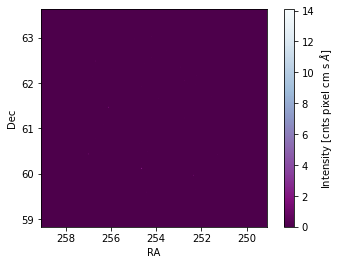

In [102]:
plt.figure()
plt.imshow(image, extent=[RA1,RAf,Dec1,Decf], cmap='BuPu_r',aspect=2)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Intensity [cnts pixel cm s $\AA$]')
plt.show()

At first glance, the image seems to be empty, however, let's change the _vmin_ and _vmax_ arguments from _imshow_ and see if we can see any difference. Since the image is 3840x3840 in size, let's only use a central smaller square to decide what limits to use (using the whole image will result in elevated computing time). A useful resource for choosing this limits is <a href="https://docs.astropy.org/en/stable/api/astropy.visualization.ZScaleInterval.html#astropy.visualization.ZScaleInterval">_ZScaleInterval_</a>, which calculates the image values near the median image, this is particularly useful for astronomical images, which generally have a very peaked histogram which can correspond to sky backgrounds.

In [16]:
cut = image[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=1.5, max_reject=0.5)
vmin, vmax = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin,', vmax = ',vmax)

Limits for image: vmin =  0.001732294768815105 , vmax =  0.004173590707020069


Now let's display the image again:

_**Note**: imshow inverts the y-axis, so when we define the extent of the Declination, we should provide the limits in the reverse order as we have defined them._

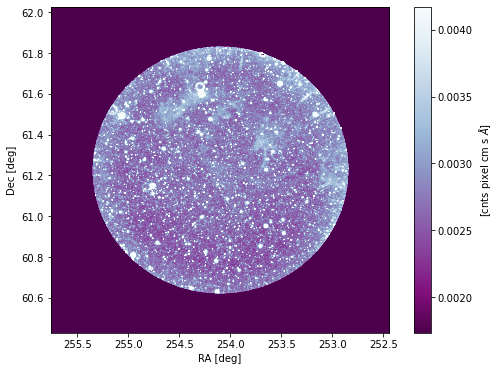

In [70]:
plt.figure(figsize=(9,6))
plt.imshow(image, extent=[RA1,RAf,Decf,Dec1], vmin=vmin, vmax=vmax, cmap='BuPu_r',aspect=2)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

Great! Now we can actually see the contents of our image.

## Constructing the final mosaic

### Additional images

Let's automate the retrieval process by creating a function `getImages` that will do all the steps we did before. In order to obtain the exact products we want automatically, we are also providing the product filename as a filter to the query, this is simply for automatization porpuses, but the steps shown before also work without this filter.

In [77]:
def getImages(RA,Dec,prod_name):
    
    """
    Obtains image from GALEX MIS database, computes limits of coordinates in axes and contrast values for image display

    Inputs:
    :param RA, Dec: coordinates of target (Right Ascension and Declination)
    :type RA, Dec: float
    :param prod_name: product filename
    :type prod_name: string
    
    Outputs: 
    :return: image 
    :rtype: ndarray
    :return: RA1, RAf, Dec1, Decf - Limits of coordinates in axes
    :rtype: float
    :return: vmin, vmax - Contrast values for image display
    :rtype: float
    """
    
    coord = SkyCoord(RA, Dec, unit='deg', frame='icrs')
    obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
    
    data_products = Observations.get_product_list(obs)
    data_products_mrp = Observations.filter_products(data_products,productFilename = prod_name, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
    yourProd = data_products_mrp[0]
    table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
    
    filename = table['Local Path'][0]
    os.system("gunzip " + filename)
    
    with fits.open(filename[:-3]) as hdulist: 
        header = hdulist[0].header
        image = hdulist[0].data
        
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    cdelt1 = header['CDELT1']
    cdelt2 = header['CDELT2']
    crpix1 = header['CRPIX1']
    crpix2 = header['CRPIX2']
    crval1 = header['CRVAL1']
    crval2 = header['CRVAL2']
    
    # Initial RA - Pixel 1
    RA1 = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    # Final RA - Last Pixel 
    RAf = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    
    # Initial Dec - Pixel 1
    Dec1 = crval2 - (crpix2-1)*cdelt2
    # Final Dec - Last Pixel 
    Decf = crval2 + (naxis2+1-crpix2)*cdelt2
    
    cut = image[1850:-1850,1850:-1850]
    interval = ZScaleInterval(nsamples=cut.size, contrast=0.75, max_reject=0.5)
    vmin, vmax = interval.get_limits(cut)
    
    return image, RA1, RAf, Dec1, Decf, vmin, vmax

Now that we have the function, let's load the parameters we need for our query first:

In [76]:
RA_draco = np.array([255.34705, 253.0000, 255.0000, 256.27741])
Dec_draco = np.array([62.03394, 63.0, 60.0,61.21117])
prod_draco = np.array(['MISGCSN2_10096_0002-nd-int.fits.gz','MISDR1_10031_0349-nd-int.fits.gz','MISDR1_10166_0351-nd-int.fits.gz','MISGCSN1_10130_0004-nd-int.fits.gz'])

And finally, let's retrieve the images:

In [78]:
n = len(RA_draco)

images_draco = []
RA1_draco = np.zeros(n)
RAf_draco = np.zeros(n)
Dec1_draco = np.zeros(n)
Decf_draco = np.zeros(n)
vmin_draco = np.zeros(n)
vmax_draco = np.zeros(n)

for i in range(n):
    image_dr, RA1_draco[i], RAf_draco[i], Dec1_draco[i], Decf_draco[i], vmin_draco[i], vmax_draco[i] = getImages(RA_draco[i],Dec_draco[i],prod_draco[i])
    images_draco.append(image_dr)

### Expanded image

In order to create our mosaic, let's add zeros to our central image to expand the field of view. We will use this expanded image to paste the additional images in it.

In [72]:
w = len(image)
new_zeros = np.zeros((w,w))
new_image = np.append(image, new_zeros, axis = 0)
new_image2 = np.insert(new_image,0,new_zeros,axis= 0)
new_zeros2 = np.zeros((w,3*w))
new_image3 = np.insert(new_image2,0,new_zeros2,axis= 1)
new_image4 = np.insert(new_image3,2*w,new_zeros2,axis= 1)

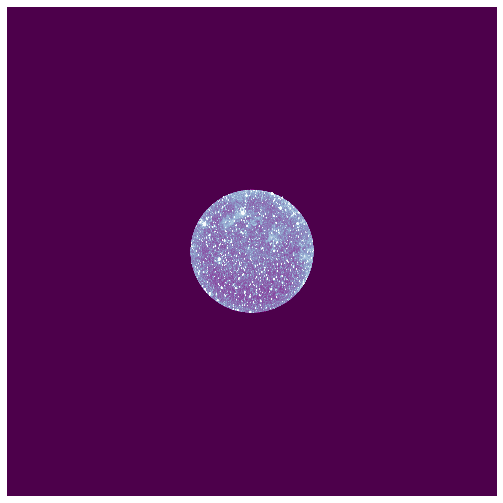

In [174]:
plt.figure(figsize = (9,9))
ax = plt.gca()
plt.imshow(new_image4, vmin=vmin, vmax=vmax, cmap='BuPu_r')
ax.invert_yaxis()
ax.axis('off')
plt.savefig('expanded.jpg',pad_inches=0,bbox_inches='tight')
plt.show()

### Saving images to local

Now let's save the rest of the images too:

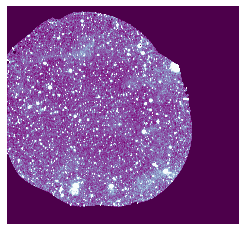

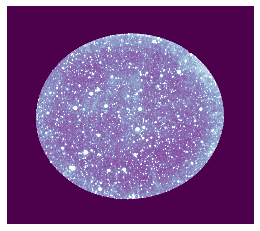

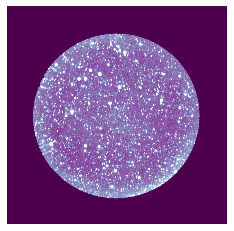

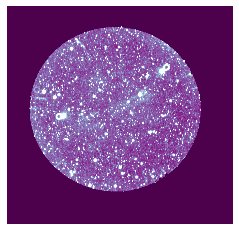

In [173]:
for i in range(len(RA1_draco)):
    plt.figure()
    ax = plt.gca()
    plt.imshow(images_draco[i], extent=[RA1_draco[i], RAf_draco[i], Dec1_draco[i], Decf_draco[i]], vmin=vmin , vmax=vmax, cmap='BuPu_r',aspect=2)
    ax.invert_yaxis()
    ax.axis('off')
    im_i = i + 2
    plt.savefig('draco'+str(im_i)+'.jpg',bbox_inches='tight')
    plt.show()

### Mask

Let's create a mask for each image in the form of a circle. We will use this to only paste the circular part of the Draco images, which is where the actual image is contained, into the mosaic. For this we will use `Image.new()`, this method creates a new image for a given mode, in our case "L" because we will create it in black and white, and size, which will be the same as its corresponding image. 

In this new image we will then draw a circle, which will be our actual mask, for this we will use `draw.ellipse()`. The parameters that we need to provide are the four points to define the box in which the ellipse will be contained and the parameter _fill_ specifies the color with which the form will be filled. Since we are using the black and white mode, it does not really matter as long as it is different from black, so we can use any color.

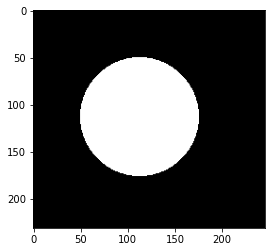

In [181]:
from PIL import Image, ImageDraw, ImageFilter

mask_im = []

for i in range(n):
    in_i = i + 2
    im2 = Image.open('draco'+str(in_i)+'.jpg')
    mask = Image.new("L", im2.size)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((50, 50, 175, 175), fill=255)
    mask_im.append(mask)

plt.figure()
plt.imshow(mask_im[0],cmap='binary_r')
plt.show()

### Limits of image - Coordinates

We need to update the limits of the expanded image, which is 3 times the size of our original one, so we can simply do the following:

In [100]:
naxis1 = header['NAXIS1']
naxis2 = header['NAXIS2']
cdelt1 = header['CDELT1']
cdelt2 = header['CDELT2']
crpix1 = header['CRPIX1']
crpix2 = header['CRPIX2']
crval1 = header['CRVAL1']
crval2 = header['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2*3-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (crpix2*3-1)*cdelt2

### Putting it all together

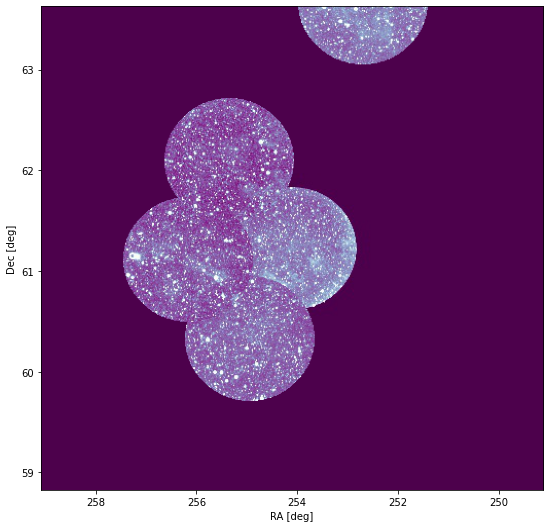

In [182]:
im1 = Image.open('expanded.jpg')
im2 = Image.open('draco2.jpg')
im3 = Image.open('draco3.jpg')
im4 = Image.open('draco4.jpg')
im5 = Image.open('draco5.jpg')

im1.paste(im2,(70,220), mask_im[0])
im1.paste(im3,(200,380), mask_im[1])
im1.paste(im4,(90,40), mask_im[2])
im1.paste(im5,(30,120), mask_im[3])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im1, extent=[RA1,RAf,Decf,Dec1],aspect=2)
ax.invert_yaxis()
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.savefig('trial.pdf',bbox_inches='tight',dpi = 1000)
plt.show()

## Exercises

TBD

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, mosaic, dust <br>
**Last Updated**: Aug 2022 <br>
**Next review**: Mar 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>